#Quantum Computing - Final project
####**Solving satisfiability problems using Grover’s Algorithm**



*   André Oliveira Barbosa
*   Miguel Angelo Mesquita Rego


---





# Tasks


* Design a solvable 3-SAT boolean formula;
* Implement Grover’s algorithm for solving the satisfiability problem;
* Assess the quality of the solution employed by the quantum algorithm;
* Study the complexity associated with the algorithm applied to your
problem, I.e., the optimal number of Grover iterations needed to reach a
solution. 



# Imports & Installs


In [ ]:
pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import qiskit.tools.jupyter

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_distribution
import matplotlib.pyplot as plt
import numpy as np

# Design a solvable 3-SAT boolean formula

Como pedido na secção de tarefas dada no enunciado, começamos por construir uma fórmula 3-SAT. Assim, tivemos em conta que esta formula tem as especificidades:
* Tem de ser satisfeita por meio de uma atribuição de valores de verdade para as suas variáveis de modo a que a tornem verdadeira;
* Tem que conter 3 variáveis em cada claúsula.

Assim, consideramos a seguinte fórmula f:

$$f(v1,v2,v3) = (v1 \lor v2 \lor v3) \land (v1 \lor \neg v2 \lor v3) \land ( \neg v1 \lor  v2 \lor v3) \land (v1 \lor v2 \lor \neg v3) \land (\neg v1 \lor v2 \lor \neg v3) \land (\neg v1 \lor \neg v2 \lor \neg v3) \land (\neg v1 \lor \neg v2 \lor v3)$$


De modo a verificar a satisfabilidade desta fórmula, elaboramos a seguinte tabela:

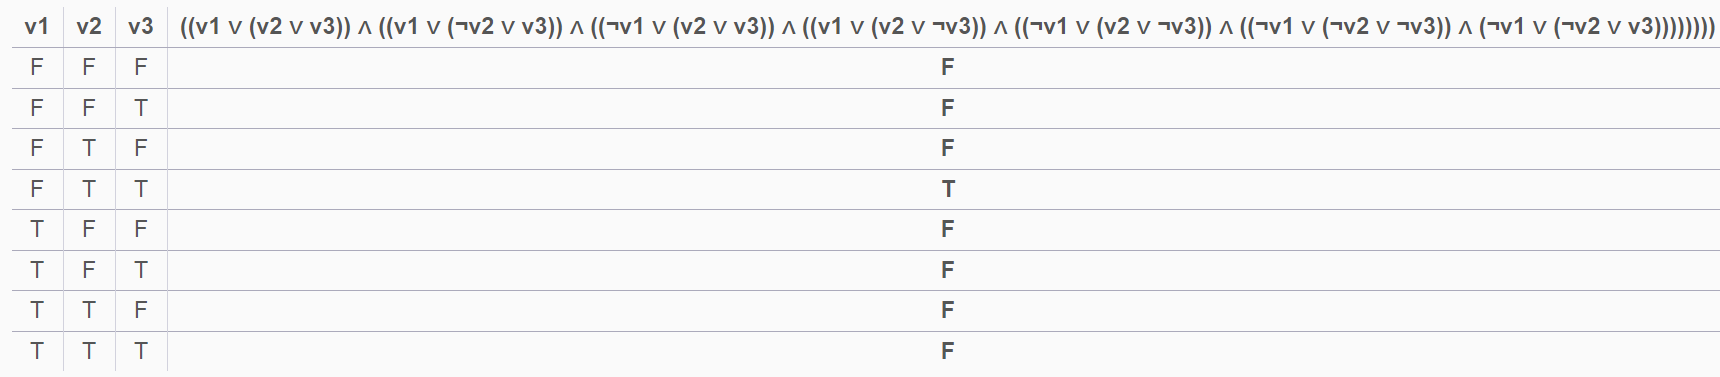

Podemos assim concluir, com base nos pontos descritos anteriormente, que estamos perante uma fórmula 3-SAT.


# Algoritmo de Grover

In [ ]:
def execute_circuit(qc, shots=1024, decimal=False):
    device = Aer.get_backend('qasm_simulator')
    counts = device.run(qc, shots=shots).result().get_counts()
    
    if decimal:
        counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
    else:
        counts = dict((a[::-1],b) for (a,b) in counts.items())

    return counts

**Inicialização** é responsável por criar uma superposição uniforme de todas as possíveis soluções do problema, permitindo que o algoritmo comece a busca de forma equilibrada.

In [ ]:
def create_circuit():
  #3 qubits que são as variaveis que vamos usar na nossa formula
  qr = QuantumRegister(3)

  #vamos usar 7 data qubits + 1 ancilla qubit
  ancilla = QuantumRegister(8)

  #Vai ser usado para guardar os valores finais quando o estado colapsar 
  cr = ClassicalRegister(3)

  #construção do circuito quantico
  qc = QuantumCircuit(qr, ancilla, cr)

  qc.h(qr)
  qc.x(ancilla)
  qc.h(ancilla)
  qc.barrier()


  return qc, qr, ancilla, cr

**Diffusion** 
tem como objetivo aumentar a amplitude da solução e diminuir a amplitude das outras entradas, aumentando asssim a probabilidade de encontrar a resposta correta na próxima iteração.

In [ ]:
def diffusion_operator(qr, ancilla):
    qc = QuantumCircuit(qr,ancilla)

    qc.h(qr)
    qc.x(qr)
    qc.h(qr[-1])

    qc.mcx(qr[:-1],qr[-1])

    qc.h(qr[-1])
    qc.x(qr)
    qc.h(qr)

    qc.barrier()

    return qc

**Oracle** é responsável por identificar se uma determinada entrada é uma solução para o problema em questão ou não, marcando a amplitude correspondente à solução.

In [ ]:
def oracle(qr, ancilla):
  qc = QuantumCircuit(qr, ancilla)

  for k in list(range(0,7)):
    #vai realizar as gates para obtermos as subformulas em cada iteração
    if k == 0:
      qc.mcx(qr,ancilla[k])
      qc.x(ancilla[k])

    if k == 1:
      qc.x(qr[1])
      qc.mcx(qr,ancilla[k])
      qc.x(ancilla[k])
      qc.x(qr[1])

    if k == 2:
      qc.x(qr[1])
      qc.x(qr[2])
      qc.mcx(qr,ancilla[k])
      qc.x(ancilla[k])
      qc.x(qr[1])
      qc.x(qr[2])

    if k == 3:
      qc.x(qr[2])
      qc.mcx(qr,ancilla[k])
      qc.x(ancilla[k])
      qc.x(qr[2])
    
    if k == 4:
      qc.x(qr[0])
      qc.x(qr[1])
      qc.mcx(qr,ancilla[k])
      qc.x(ancilla[k])
      qc.x(qr[0])
      qc.x(qr[1])
    
    if k == 5:
      qc.x(qr[0])
      qc.x(qr[1])
      qc.x(qr[2])
      qc.mcx(qr,ancilla[k])
      qc.x(ancilla[k])
      qc.x(qr[0])
      qc.x(qr[1])
      qc.x(qr[2])
    
    if k == 6:
      qc.x(qr[0])
      qc.x(qr[2])
      qc.mcx(qr,ancilla[k])
      qc.x(ancilla[k])
      qc.x(qr[0])
      qc.x(qr[2])

    #calcula o valor final da formula
  qc.mcx(ancilla[:-1], ancilla[-1])
  qc.x(ancilla[-1])

  qc.barrier()
  return qc

In [ ]:
#Grover algorithm
def grover(qc, qr, ancilla, oracle):
  num_iterations = int(np.floor(np.pi /4 * np.sqrt(2**3)))

  for i in range(num_iterations):
    qc = qc.compose(oracle(qr,ancilla))
    qc = qc.compose(diffusion_operator(qr,ancilla))

  return qc

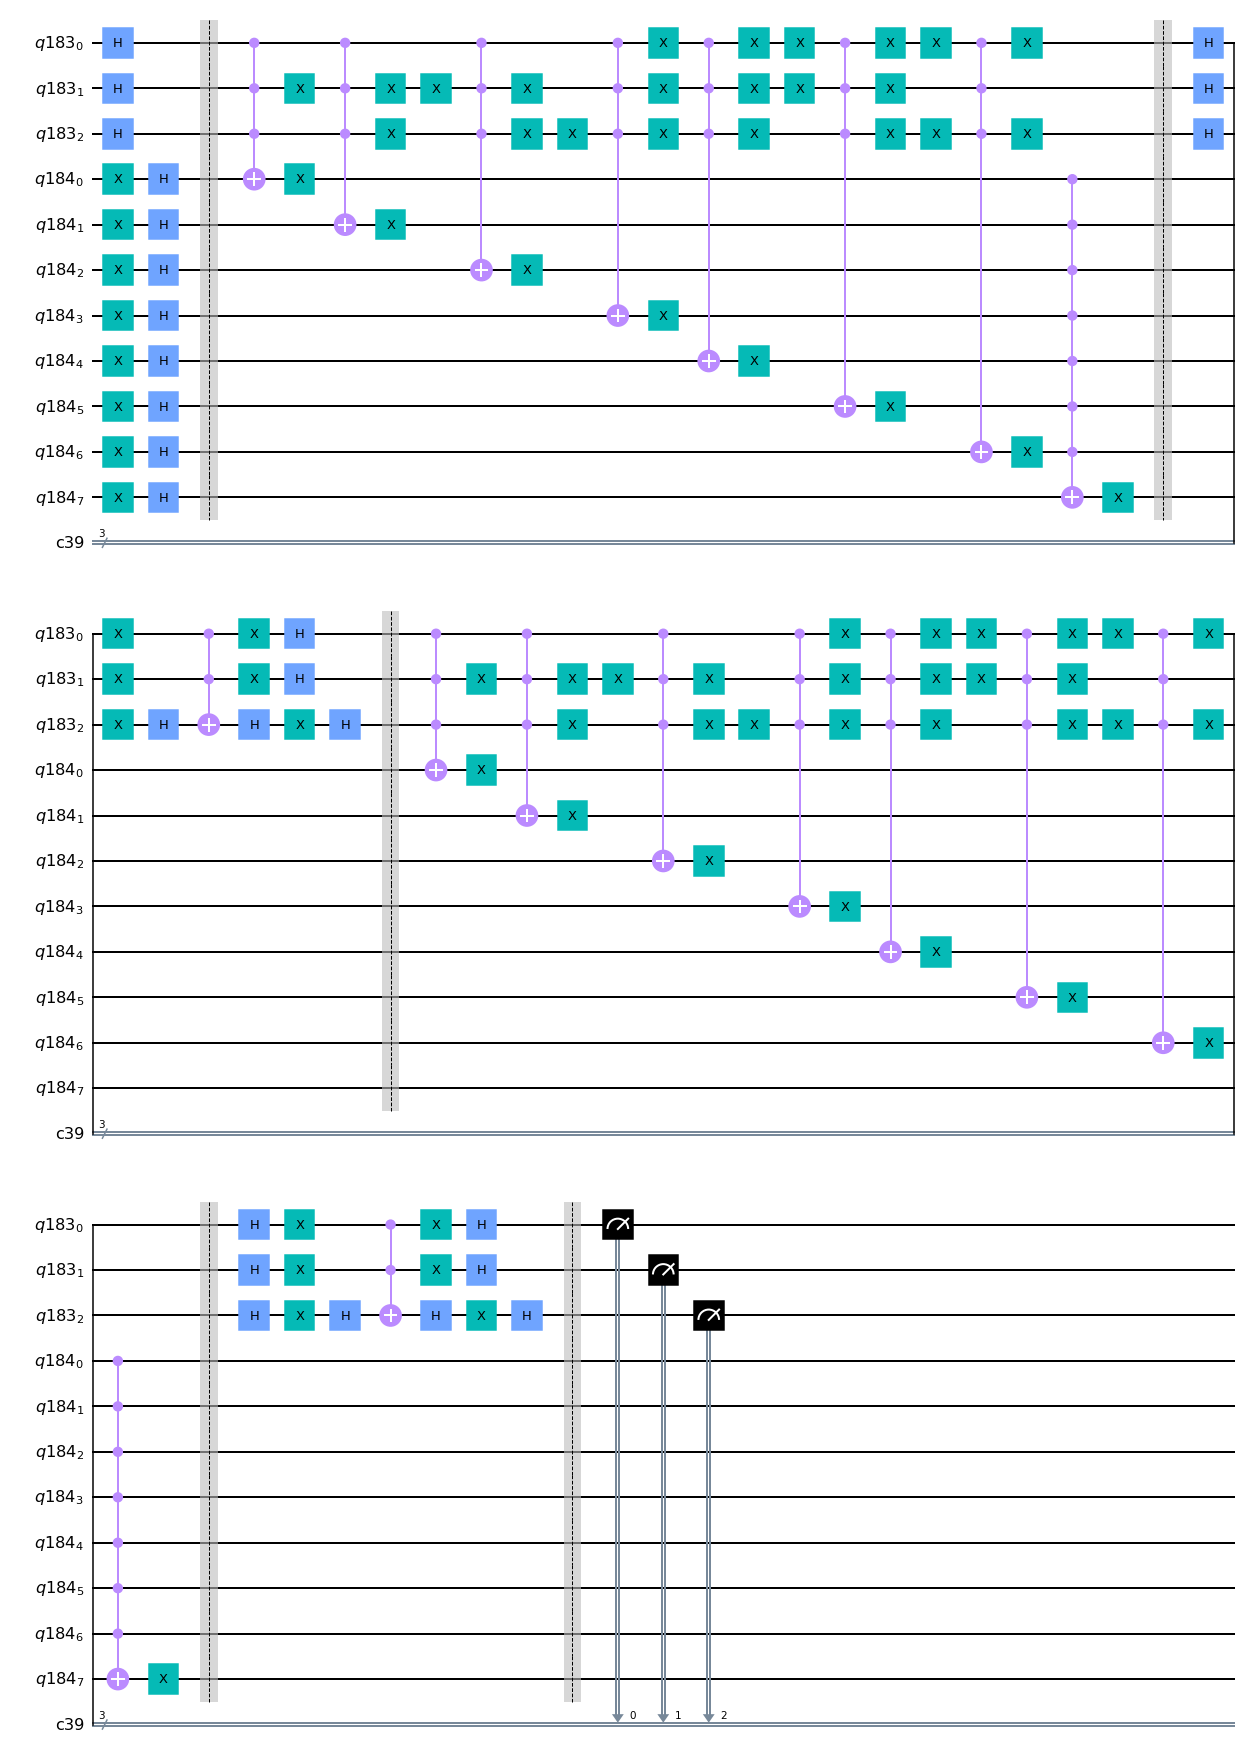

In [ ]:
qc, qr, ancilla, cr = create_circuit()
qc = grover(qc,qr,ancilla,oracle)
qc.measure(qr,cr)
qc.draw(output = "mpl")

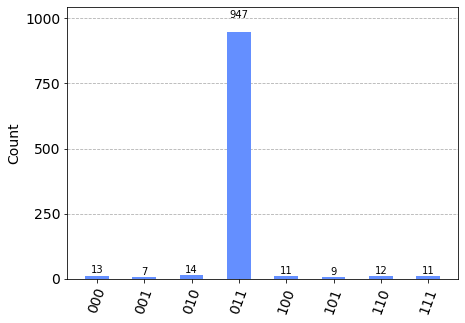

In [ ]:
plot_histogram(execute_circuit(qc,1024))

#Solução obtida com 1 iteração

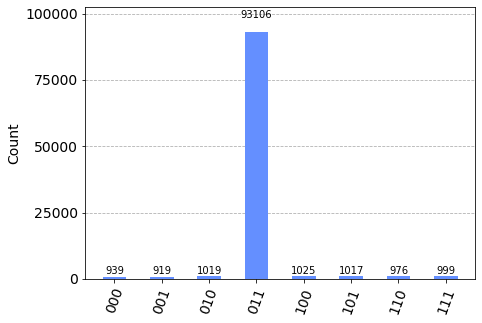

In [ ]:
#Com 1 iteração 
def groverone(qc, qr, ancilla, oracle):
  num_iterations = int(np.floor(np.pi /4 * np.sqrt(2**3)))

  qc = qc.compose(oracle(qr,ancilla))
  qc = qc.compose(diffusion_operator(qr,ancilla))
  return qc

qc, qr, ancilla, cr = create_circuit()
qc = grover(qc,qr,ancilla,oracle)
qc.measure(qr,cr)
qc.draw(output = "mpl")

plot_histogram(execute_circuit(qc, 100000))

#Solução obtida com 3 iterações

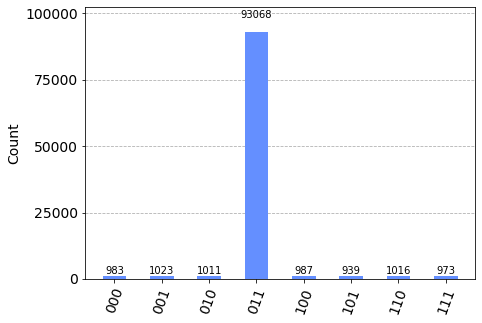

In [ ]:
#Com 3 iterações
def groverthree(qc, qr, ancilla, oracle):
  num_iterations = int(np.floor(np.pi /4 * np.sqrt(2**3)))
  
  for j in range(3):
    qc = qc.compose(oracle(qr,ancilla))
    qc = qc.compose(diffusion_operator(qr,ancilla))
  return qc

qc, qr, ancilla, cr = create_circuit()
qc = grover(qc,qr,ancilla,oracle)
qc.measure(qr,cr)
qc.draw(output = "mpl")

plot_histogram(execute_circuit(qc, 100000))

#Conclusão

Pelo resultado acima podemos concluir que o algoritmo tem uma probabilidade acima de obter a solução correta é de acima de 95% o que demonstra a excelente precisão do algoritmo.

O grau de complexidade é, tal como mostrado nas aulas, de $O(\sqrt N)$, e o número de iterações ideal é 2, dado que é nesse caso que a sua precisão é maior (face à precisão de 93% no caso de 1 e 3 iterações.).

Consideramos que este trabalho prático foi essencial para consolidar os nossos conhecimentos nesta área e que foi um desafio bastante interessante. 
Foi também enriquecedor entender as vantagens o funcionamento deste algoritmo quantico.
Por fim, entendemos que fomos ao encontro de todas as tarefas propostas no enunciado do projeto e que as cumprimos com sucesso.

# Referências:

*   Satisfiability with Grover - https://qiskit.org/textbook/ch-applications/satisfiability-grover.html
*   Grover’s algorithm - Qiskit - https://qiskit.org/textbook/ch-algorithms/grover.html
*   BlackBoard





